## Introduction

This project aims to develop a machine learning model for predicting sepsis in patients based on various clinical features. Sepsis is a life-threatening condition that arises when the body's response to an infection causes inflammation throughout the body. Early detection and timely intervention are critical for improving patient outcomes in sepsis cases.

## Objectives

1.Develop a predictive model to identify patients at risk of developing sepsis.

2.Utilize machine learning techniques to analyze clinical data and extract patterns indicative of sepsis.

3.Provide healthcare professionals with a tool for early detection and intervention in sepsis cases.

## Business Understanding

**Problem Statement**

Sepsis is a leading cause of morbidity and mortality worldwide, with delayed recognition and treatment contributing to poor patient outcomes. The lack of efficient tools for early sepsis detection in clinical settings poses a significant challenge for healthcare providers.


**Stakeholders**

-Healthcare Professionals: Physicians, nurses, and other medical staff responsible for patient care.

-Patients: Individuals at risk of developing sepsis or already diagnosed with sepsis.

-Hospital Administrators: Decision-makers responsible for implementing new technologies and protocols for patient management.

**Value Proposition**
The development of an accurate and efficient sepsis prediction model offers the following benefits:

Early Detection: Prompt identification of patients at risk of sepsis allows for timely intervention and improved outcomes.
Resource Optimization: Allocation of medical resources and interventions to high-risk patients, optimizing healthcare delivery.
Cost Reduction: Preventing sepsis-related complications and reducing the financial burden on healthcare systems.

**Analytica Questions**

1.What is the distribution of Sepsis

2.What is the distribution of Age

3.How Many Patients have Insurance

4.Is Blood Pressure Affected by Age

5.How many patients in each BMI category have sepsis?


## Hypothesis

Null Hypothesis (H0): There is no significant relationship between a patient's age and the likelihood of developing sepsis.

Alternative Hypothesis (H1): The age of a patient is a significant factor that influences the likelihood of developing sepsis.

In [329]:
# Data Processing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
from scipy.stats import skew

# Data Splitting and Models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# Evaluation Metrics
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score
import pickle

# Saving Model
from joblib import dump

# Others
import shap
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.linear_model import SGDClassifier
import warnings

# Set seaborn defaults and suppress warnings
sns.set()
warnings.filterwarnings('ignore')

In [330]:
# load train and test data
train_df = pd.read_csv('datasets\Paitients_Files_Train.csv')
test_df = pd.read_csv('datasets\Paitients_Files_Test.csv')

**Data Understanding**

-ID: number to represent patient ID

-PRG: Plasma glucose

-PL: Blood Work Result-1 (mu U/ml)

-PR: Blood Pressure (mmHg)

-SK: Blood Work Result-2(mm)

-TS: Blood Work Result-3 (muU/ml)

-M11: Body mass index (weight in kg/(height in m)^2

-BD2: Blood Work Result-4 (mu U/ml)

-Age: patients age(years)

-Insurance: If a patient holds a valid insurance card

-Sepsis: Positive: if a patient in ICU will develop a sepsis , and Negative: otherwis otherwise

In [331]:
#checking the number of rows an columns for both the train and data set
train_df.shape,test_df.shape

((599, 11), (169, 10))

In [332]:
#first five rows of the train data
train_df.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


In [333]:
#first five rows of test data
test_df.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,ICU200609,1,109,38,18,120,23.1,0.407,26,1
1,ICU200610,1,108,88,19,0,27.1,0.400,24,1
2,ICU200611,6,96,0,0,0,23.7,0.190,28,1
3,ICU200612,1,124,74,36,0,27.8,0.100,30,1
4,ICU200613,7,150,78,29,126,35.2,0.692,54,0


In [334]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


No missing values but Sepsis is wrongly mispelled as Sepssis.

In [335]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         169 non-null    object 
 1   PRG        169 non-null    int64  
 2   PL         169 non-null    int64  
 3   PR         169 non-null    int64  
 4   SK         169 non-null    int64  
 5   TS         169 non-null    int64  
 6   M11        169 non-null    float64
 7   BD2        169 non-null    float64
 8   Age        169 non-null    int64  
 9   Insurance  169 non-null    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 13.3+ KB


The sepsis column is missing unlike in the train dataset

In [336]:
# Descriptive statistics of the train dataset
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PRG,599.0,3.824708,3.362839,0.000,1.000,3.000,6.000,17.00
PL,599.0,120.153589,32.682364,0.000,99.000,116.000,140.000,198.00
PR,599.0,68.732888,19.335675,0.000,64.000,70.000,80.000,122.00
SK,599.0,20.562604,16.017622,0.000,0.000,23.000,32.000,99.00
TS,599.0,79.460768,116.576176,0.000,0.000,36.000,123.500,846.00
M11,599.0,31.920033,8.008227,0.000,27.100,32.000,36.550,67.10
BD2,599.0,0.481187,0.337552,0.078,0.248,0.383,0.647,2.42
Age,599.0,33.290484,11.828446,21.000,24.000,29.000,40.000,81.00
Insurance,599.0,0.686144,0.464447,0.000,0.000,1.000,1.000,1.00


In [337]:
# Categories in the Sepssis column
train_df['Sepssis'].value_counts()

Sepssis
Negative    391
Positive    208
Name: count, dtype: int64

## Exploratory Data Analysis

1. What the distribution of sepsis?

In [338]:
# Distribution of Sepssis
px.histogram(train_df["Sepssis"])


There are 391 negative cases which are the patients who did not develop sepsis during their stay in the intensive Care Unit(ICU). The positive cases are 208, which are the patients who developed sepsis during their stay in the ICU.

## 2. What is the distribution of ages for patients captured in the data?

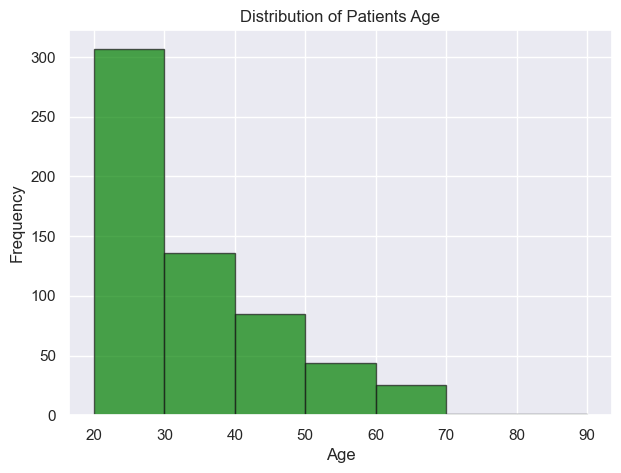

Mean Age: 33.29
Median Age: 29.0
Minimum Age: 21
Maximum Age: 81


In [339]:
# We plot the distribution of ages for all the patients
plt.figure(figsize=(7,5))
plt.hist(train_df['Age'],bins=7,range = (20,90),edgecolor='k',alpha=0.7,color='green')
plt.title("Distribution of Patients Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Calculating the summary statistics of the age column
mean_age = train_df['Age'].mean()
median_age = train_df['Age'].median()
min_age = train_df['Age'].min()
max_age = train_df['Age'].max()

# Print summary statistics
print(f"Mean Age: {mean_age:.2f}")
print(f"Median Age: {median_age}")
print(f"Minimum Age: {min_age}")
print(f"Maximum Age: {max_age}")

## 3. How many patients have insurance?

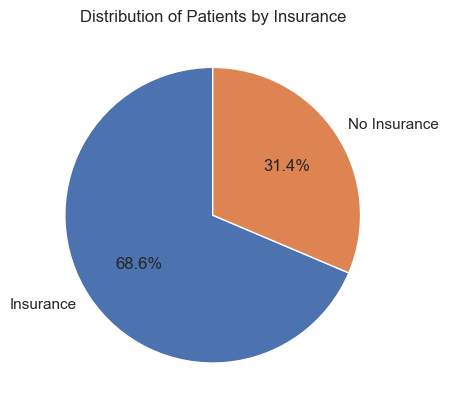

In [340]:
#We count the number of patients with insurance
insurance_count = train_df['Insurance'].value_counts()
labels = ['Insurance','No Insurance']
plt.title('Distribution of Patients by Insurance')
# We plot the pie chart
plt.pie(insurance_count,labels=labels,autopct='%1.1f%%', startangle=90)
plt.show()

## 4. Is Blood Pressure affected by Age?

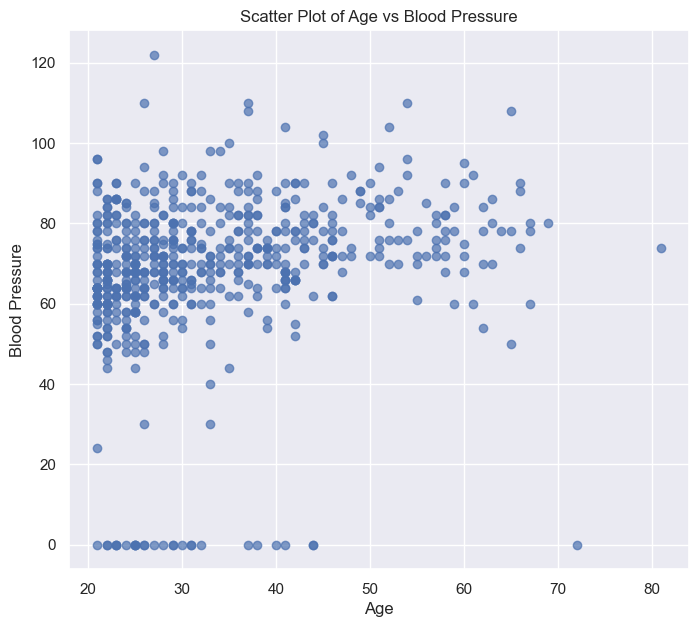

In [341]:
plt.figure(figsize=(8,7))
plt.scatter(train_df['Age'],train_df['PR'],alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Blood Pressure')
plt.title("Scatter Plot of Age vs Blood Pressure")
plt.show()

Most of the Values lie between 40 and 80. This represents the systolic or diastolic blood pressure values. Most of the values cluster within this range which indicates that blood pressure tends to be within a relatively normal or typical range for a large portion of the population in the dataset.

## Hypothesis Testing

In [342]:
# We define Negative and Positive Sepsis Cases
Sepsis_Negative = train_df[train_df['Sepssis']=='Negative']
Sepsis_Positive = train_df[train_df['Sepssis']=='Positive']

In [343]:
t,p = stats.ttest_ind(Sepsis_Negative['Age'],Sepsis_Positive['Age'],equal_var=False)

In [344]:
print(p)

1.0859592786305662e-07


In [345]:
# Separate data into two groups: patients with sepsis (Sepsis: Positive) and without sepsis (Sepsis: Negative)
sepsis_positive = train_df[train_df['Sepssis'] == 'Positive']['Age']
sepsis_negative = train_df[train_df['Sepssis'] == 'Negative']['Age']

In [346]:
# Set significance level (alpha)
alpha = 0.05

 # Perform a two-sample independent t-test
t_stat, p_value = stats.ttest_ind(sepsis_positive, sepsis_negative, equal_var=False)

In [347]:
# Print the t-statistic and p-value
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 5.398028835705048
P-value: 1.0859592786305662e-07


In [348]:
# Compare p-value to alpha to make a decision
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in age between patients with and without sepsis.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in age between patients with and without sepsis.")

Reject the null hypothesis. There is a significant difference in age between patients with and without sepsis.


<Axes: xlabel='Age', ylabel='Count'>

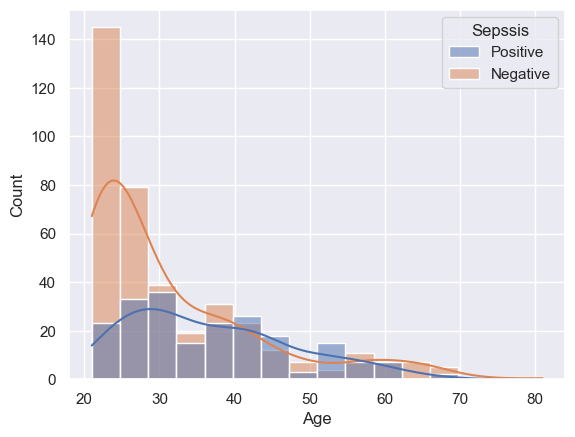

In [349]:
sns.histplot(data=train_df,x='Age',hue='Sepssis',kde=True)

Data Cleaning 

In [350]:
#showing the columns
train_df.columns

Index(['ID', 'PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance',
       'Sepssis'],
      dtype='object')

In [351]:
#dropping the ID column
train_df.drop(['ID'], axis=1, inplace=True)

In [352]:
print(train_df.columns)

Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance',
       'Sepssis'],
      dtype='object')


In [353]:
#correcting the typo in Sepsis column
train_df.rename(columns={'Sepssis': 'Sepsis'}, inplace=True)

In [354]:
train_df.isna().sum()

PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepsis       0
dtype: int64

In [355]:
#creating dataframe copy
train_df_copy=train_df.copy()

In [356]:
#maping the Sepsis column with Negative=0 and Positive =1
train_df_copy=train_df['Sepsis'].map({'Negative':0,'Positive':1})

In [357]:
train_df_copy.head()

0    1
1    0
2    1
3    0
4    1
Name: Sepsis, dtype: int64

## Data Preparation

In [358]:
#check if dataset is balanced
sepsis_count = train_df['Sepsis'].value_counts().rename('sepsis_count').reset_index()
sepsis_count

,Sepsis,sepsis_count
0,Negative,391
1,Positive,208


In [359]:
# Renaming the seppsis, BMI and Blood pressure columns
train = train_df.rename(columns={'M11': 'BMI'})
train = train_df.rename(columns={'PR': 'BP'})

# Test dataset
test = test_df.rename(columns={'M11': 'BMI'})
test = test_df.rename(columns={'PR': 'BP'})

train.head()

,PRG,PL,BP,SK,TS,M11,BD2,Age,Insurance,Sepsis
0,6,148,72,35,0,33.6,0.627,50,0,Positive
1,1,85,66,29,0,26.6,0.351,31,0,Negative
2,8,183,64,0,0,23.3,0.672,32,1,Positive
3,1,89,66,23,94,28.1,0.167,21,1,Negative
4,0,137,40,35,168,43.1,2.288,33,1,Positive


In [360]:
#drop the ID column in the test dataset
test.drop(['ID'],axis=1,inplace=True)

In [361]:
test.head()

,PRG,PL,BP,SK,TS,M11,BD2,Age,Insurance
0,1,109,38,18,120,23.1,0.407,26,1
1,1,108,88,19,0,27.1,0.400,24,1
2,6,96,0,0,0,23.7,0.190,28,1
3,1,124,74,36,0,27.8,0.100,30,1
4,7,150,78,29,126,35.2,0.692,54,0


In [362]:
train_df.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepsis
0,6,148,72,35,0,33.6,0.627,50,0,Positive
1,1,85,66,29,0,26.6,0.351,31,0,Negative
2,8,183,64,0,0,23.3,0.672,32,1,Positive
3,1,89,66,23,94,28.1,0.167,21,1,Negative
4,0,137,40,35,168,43.1,2.288,33,1,Positive


## Feature Encoding

In [363]:
def encode_target_variable(train_df, target_variable):
    # Encode the target variable using LabelEncoder
    label_encoder = LabelEncoder()
    encoded_target = label_encoder.fit_transform(train_df[target_variable])
    target_encoded = pd.DataFrame(encoded_target, columns=[target_variable])

    # Combine the features and the encoded target variable
    df = pd.concat([train_df.iloc[:, :-1], target_encoded], axis=1)

    return df



In [364]:
# Encode target variable in train data
train_encoded = encode_target_variable(train_df, 'Sepsis')

# Print the encoded train data
print(train_encoded.head())

   PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance  Sepsis
0    6  148  72  35    0  33.6  0.627   50          0       1
1    1   85  66  29    0  26.6  0.351   31          0       0
2    8  183  64   0    0  23.3  0.672   32          1       1
3    1   89  66  23   94  28.1  0.167   21          1       0
4    0  137  40  35  168  43.1  2.288   33          1       1


## Dataset Splitting

In [409]:
def split_data(X, y, test_size, random_state=42, stratify=None):
    # Split the data into train and validation sets
    X_train, X_eval, y_train, y_eval= train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=stratify)

    return X_train, X_eval, y_train, y_eval

In [410]:
# Split the data into train and validation sets for both X and y
X_train, X_eval, y_train, y_eval= split_data(train_encoded.iloc[:, :-1], train_encoded.iloc[:, -1:], test_size=0.2, random_state=42, stratify=train_encoded.iloc[:, -1:])


## Features Scaling

In [367]:
scaler = StandardScaler()
scaler.fit(X_train)

columns = ['PRG','PL','PR','SK','TS','M11','BD2','Age','Insurance']

def scale_data(data, scaler, columns):
    scaled_data = scaler.transform(data)
    scaled_df = pd.DataFrame(scaled_data, columns=columns)
    return scaled_df

In [368]:
# Scale the data
X_train_df = scale_data(X_train, scaler, columns)
X_eval_df = scale_data(X_eval, scaler, columns)

Machine Learning Modeling

Here is the section to build, train, evaluate and compare the models to each others.

In [369]:
def logistic_regression_model(X_train, y_train, X_eval, y_eval):
    # Fit logistic regression model
    lr_model = LogisticRegression()
    lr_model.fit(X_train, y_train)

    # Make predictions on the evaluation set
    lr_preds = lr_model.predict(X_eval)

    # Calculate F1 score
    lr_f1_score = f1_score(y_eval, lr_preds)

    # Calculate false positive rate, true positive rate, and thresholds using roc_curve
    fpr, tpr, thresholds = roc_curve(y_eval, lr_preds)

    # Calculate AUC score
    lr_auc_score = roc_auc_score(y_eval, lr_preds)

    return lr_model, lr_preds, lr_f1_score, fpr, tpr, thresholds, lr_auc_score

In [370]:
# Call the function and get the outputs
lr_model, lr_preds, lr_f1_score, fpr, tpr, thresholds, lr_auc_score = logistic_regression_model(X_train_df, y_train, X_eval_df, y_eval)

print("F1 Score:", lr_f1_score)
print("AUC Score:", lr_auc_score)

F1 Score: 0.6265060240963856
AUC Score: 0.7133699633699634


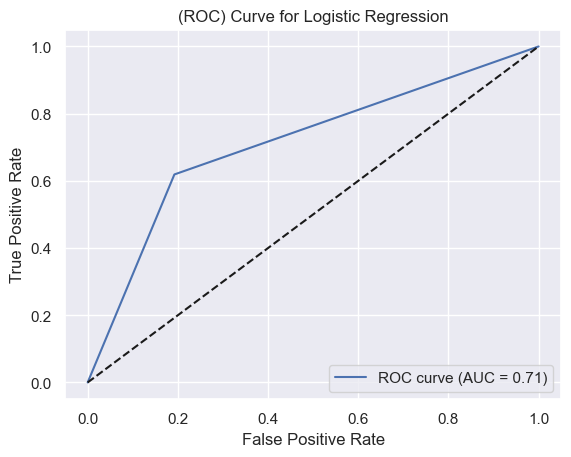

In [371]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % lr_auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

Checking for overfitting

In [372]:
# Define the function to calculate F1 score
def calculate_f1_score(model, X, y):
    y_pred = model.predict(X)
    return f1_score(y, y_pred)


# Calculate F1 scores for training and evaluation sets
lr_train_f1_score = calculate_f1_score(lr_model, X_train_df, y_train)
lr_eval_f1_score = calculate_f1_score(lr_model, X_eval_df, y_eval)

# Print the F1 scores
print("F1 Score on Training Set:", lr_train_f1_score)
print("F1 Score on Evaluation Set:", lr_eval_f1_score)

F1 Score on Training Set: 0.6486486486486487
F1 Score on Evaluation Set: 0.6265060240963856


In [373]:
def calculate_f1_score(model, X, y):
    predictions = model.predict(X)
    f1 = f1_score(y, predictions)
    return f1

In [374]:
# Calculate F1 scores for training and evaluation sets
Lr_train_f1_score = calculate_f1_score(lr_model, X_train_df, y_train)
lr_eval_f1_score = calculate_f1_score(lr_model, X_eval_df, y_eval)

# Print the F1 scores
print("F1 Score on Training Set:", Lr_train_f1_score)
print("F1 Score on Evaluation Set:", lr_eval_f1_score)

F1 Score on Training Set: 0.6486486486486487
F1 Score on Evaluation Set: 0.6265060240963856


In [375]:
def perform_cross_validation(model, X, y, cv=5, scoring='f1'):
    # Perform cross-validation
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)

    # Calculate the average score
    avg_score = np.mean(cv_scores)

    return cv_scores, avg_score

In [376]:
# Perform cross-validation
def perform_cross_validation(model, X, y, cv=5, scoring='f1'):
    # Perform cross-validation
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)

    # Calculate the average score
    avg_score = np.mean(cv_scores)

    return cv_scores, avg_score
# Call the function with your logistic regression model and train data
cv_scores, avg_f1_score = perform_cross_validation(lr_model, X_train_df, y_train, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores:", cv_scores)
print("Average F1 Score:", avg_f1_score)

Cross-Validation Scores: [0.6557377  0.64615385 0.65384615 0.55555556 0.70967742]
Average F1 Score: 0.6441941359656855


In [377]:
def evaluate_decision_tree(X_train, y_train, X_eval, y_eval):
    # Create and fit the decision tree classifier model
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train, y_train)

    # Make predictions on the evaluation set
    dt_pred = dt_model.predict(X_eval)

    # Calculate the F1 score
    dt_f1_score = f1_score(y_eval, dt_pred)

    # Calculate the false positive rate, true positive rate, and thresholds using roc_curve
    fpr, tpr, thresholds = roc_curve(y_eval, dt_pred)

    # Calculate the AUC (Area Under the Curve)
    dt_auc_score = roc_auc_score(y_eval, dt_pred)
    return dt_model, dt_pred, dt_f1_score, dt_auc_score

In [378]:
# Call the function with your train and evaluation data
dt_model, dt_pred, dt_f1_score, dt_auc_score = evaluate_decision_tree(X_train_df, y_train, X_eval_df, y_eval)

print("F1 Score:", dt_f1_score)
print("AUC Score:", dt_auc_score)

F1 Score: 0.6024096385542169
AUC Score: 0.6950549450549451


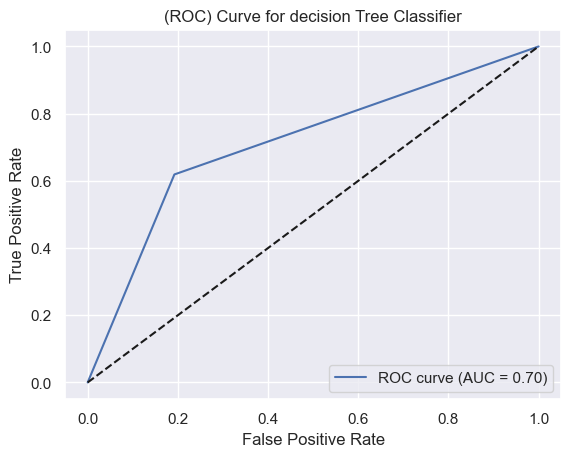

In [379]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % dt_auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for decision Tree Classifier')
plt.legend(loc='lower right')
plt.show()


Checking for overfitting

In [380]:
# Calculate F1 scores for training and evaluation sets
dt_train_f1_score = calculate_f1_score(dt_model, X_train_df, y_train)
dt_eval_f1_score = calculate_f1_score(dt_model, X_eval_df, y_eval)

# Print the F1 scores
print("F1 Score on Training Set:", dt_train_f1_score)
print("F1 Score on Evaluation Set:", dt_eval_f1_score)

F1 Score on Training Set: 1.0
F1 Score on Evaluation Set: 0.6024096385542169


In [381]:
# Call the function with your logistic regression model and train data
cv_scores, avg_f1_score = perform_cross_validation(dt_model, X_train_df, y_train, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores:", cv_scores)
print("Average F1 Score:", avg_f1_score)

Cross-Validation Scores: [0.49180328 0.57142857 0.43636364 0.58461538 0.4516129 ]
Average F1 Score: 0.5071647548643846


In [382]:
def random_forest_model(X_train, y_train, X_eval, y_eval):
    # Fit Random Forest model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    # Make predictions on the evaluation set
    rf_preds = rf_model.predict(X_eval)

    # Calculate F1 score
    rf_f1_score = f1_score(y_eval, rf_preds)

    # Calculate false positive rate, true positive rate, and thresholds using roc_curve
    fpr, tpr, thresholds = roc_curve(y_eval, rf_preds)

    # Calculate AUC score
    rf_auc_score = roc_auc_score(y_eval, rf_preds)

    return rf_model, rf_preds, rf_f1_score, fpr, tpr, thresholds, rf_auc_score

In [383]:
rf_model, rf_preds, rf_f1_score, fpr, tpr, thresholds, rf_auc_score = random_forest_model(X_train, y_train, X_eval, y_eval)

print("F1 Score:", rf_f1_score)
print("AUC Score:", rf_auc_score)

F1 Score: 0.5783132530120482
AUC Score: 0.6767399267399268


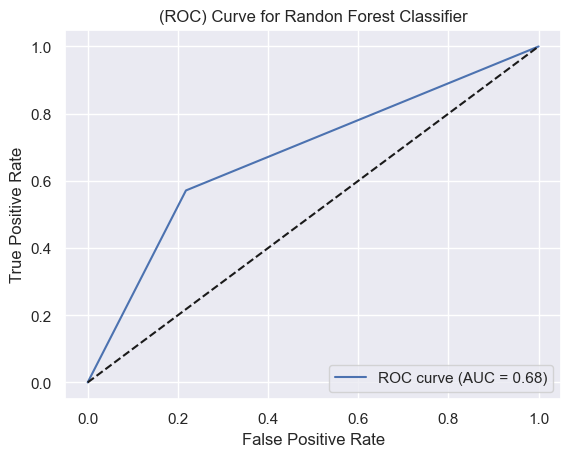

In [384]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % rf_auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for Randon Forest Classifier')
plt.legend(loc='lower right')
plt.show()

In [385]:
# Calculate F1 scores for training and evaluation sets
rf_train_f1_score = calculate_f1_score(rf_model, X_train_df, y_train)
rf_eval_f1_score = calculate_f1_score(rf_model, X_eval_df, y_eval)

# Print the F1 scores
print("F1 Score on Training Set based on Random Forest:", rf_train_f1_score)
print("F1 Score on Evaluation Set based on Random Forest:", rf_eval_f1_score)

F1 Score on Training Set based on Random Forest: 0.0
F1 Score on Evaluation Set based on Random Forest: 0.0


In [386]:
# Call the function with your Random Forest model and train data
cv_scores, avg_f1_score = perform_cross_validation(rf_model, X_train_df, y_train, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores:", cv_scores)
print("Average F1 Score:", avg_f1_score)

Cross-Validation Scores: [0.73846154 0.65671642 0.54901961 0.54545455 0.61290323]
Average F1 Score: 0.6205110670952242


In [387]:
def xgboost_model(X_train, y_train, X_eval, y_eval):
    # Fit XGBoost model
    xgb_model = XGBClassifier()
    xgb_model.fit(X_train, y_train)

    # Make predictions on the evaluation set
    xgb_preds = xgb_model.predict(X_eval)

    # Calculate F1 score
    xgb_f1_score = f1_score(y_eval, xgb_preds)

    # Calculate false positive rate, true positive rate, and thresholds using roc_curve
    fpr, tpr, thresholds = roc_curve(y_eval, xgb_preds)

    # Calculate AUC score
    xgb_auc_score = roc_auc_score(y_eval, xgb_preds)

    return xgb_model, xgb_preds, xgb_f1_score, fpr, tpr, thresholds, xgb_auc_score

In [388]:
xgb_model, xgb_preds, xgb_f1_score, fpr, tpr, thresholds, xgb_auc_score = xgboost_model(X_train_df, y_train, X_eval_df, y_eval)

# Print the F1 score and AUC score
print("F1 Score on Evaluation Set based on XGBoost:", xgb_f1_score)
print("AUC Score on Evaluation Set based on XGBoost:", xgb_auc_score)

F1 Score on Evaluation Set based on XGBoost: 0.5882352941176471
AUC Score on Evaluation Set based on XGBoost: 0.6822344322344323


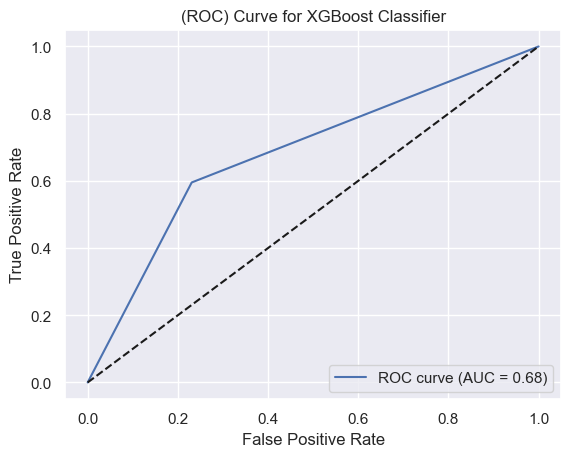

In [389]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % xgb_auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for XGBoost Classifier')
plt.legend(loc='lower right')
plt.show()

In [390]:
# Calculate F1 scores for training and evaluation sets
xgb_train_f1_score = calculate_f1_score(xgb_model, X_train_df, y_train)
xgb_eval_f1_score = calculate_f1_score(xgb_model, X_eval_df, y_eval)

# Print the F1 scores
print("F1 Score on Training Set based on XGboost:", xgb_train_f1_score)
print("F1 Score on Evaluation Set based on XGboost:", xgb_eval_f1_score)

F1 Score on Training Set based on XGboost: 1.0
F1 Score on Evaluation Set based on XGboost: 0.5882352941176471


In [391]:
# Call the function with your XGboost model and train data
cv_scores, avg_f1_score = perform_cross_validation(xgb_model, X_train_df, y_train, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores based on XGboost:", cv_scores)
print("Average F1 Score based on XGboost:", avg_f1_score)

Cross-Validation Scores based on XGboost: [0.65671642 0.67647059 0.5        0.56666667 0.60606061]
Average F1 Score based on XGboost: 0.601182855774603


In [392]:
def naive_bayes_model(X_train, y_train, X_eval, y_eval):
    # Fit Naive Bayes model
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)

    # Make predictions on the evaluation set
    nb_preds = nb_model.predict(X_eval)

    # Calculate F1 score
    nb_f1_score = f1_score(y_eval, nb_preds)

    # Calculate false positive rate, true positive rate, and thresholds using roc_curve
    fpr, tpr, thresholds = roc_curve(y_eval, nb_preds)

    # Calculate AUC score
    nb_auc_score = roc_auc_score(y_eval, nb_preds)

    return nb_model, nb_preds, nb_f1_score, fpr, tpr, thresholds, nb_auc_score

In [393]:
nb_model, nb_preds, nb_f1_score, fpr, tpr, thresholds, nb_auc_score = naive_bayes_model(X_train_df, y_train, X_eval_df, y_eval)

# Print the F1 score and AUC score
print("F1 Score on Evaluation Set based on Naive Bayes:", nb_f1_score)
print("AUC Score on Evaluation Set based on Naive Bayes:", nb_auc_score)

F1 Score on Evaluation Set based on Naive Bayes: 0.5747126436781609
AUC Score on Evaluation Set based on Naive Bayes: 0.6694139194139194


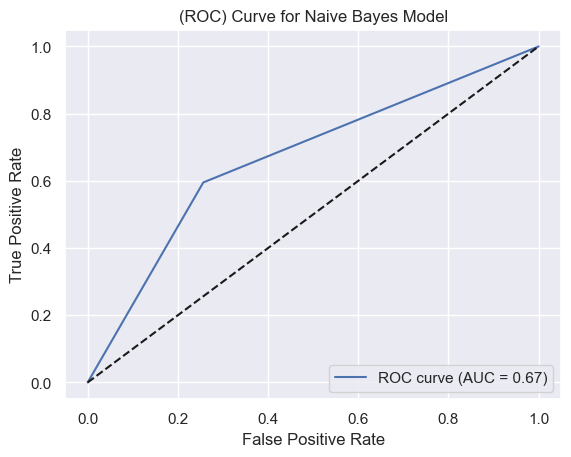

In [394]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % nb_auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for Naive Bayes Model')
plt.legend(loc='lower right')
plt.show()

In [395]:
# Calculate F1 scores for training and evaluation sets
nb_train_f1_score = calculate_f1_score(nb_model, X_train_df, y_train)
nb_eval_f1_score = calculate_f1_score(nb_model, X_eval_df, y_eval)

# Print the F1 scores
print("F1 Score on Training Set based on Naive Bayes:", nb_train_f1_score)
print("F1 Score on Evaluation Set based on Naive Bayes:", nb_eval_f1_score)

F1 Score on Training Set based on Naive Bayes: 0.6730769230769231
F1 Score on Evaluation Set based on Naive Bayes: 0.5747126436781609


In [396]:
# Call the function with your Naive Bayes model and train data
cv_scores, avg_f1_score = perform_cross_validation(nb_model, X_train_df, y_train, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores based on Naive Bayes model:", cv_scores)
print("Average F1 Score based on Naive Bayes model:", avg_f1_score)

Cross-Validation Scores based on Naive Bayes model: [0.70769231 0.6        0.7        0.63157895 0.67741935]
Average F1 Score based on Naive Bayes model: 0.6633381219798877


In [397]:
def sgd_model_func(X_train, y_train, X_eval, y_eval):
    # Fit SGD model
    sgd_model = SGDClassifier()
    sgd_model.fit(X_train, y_train)

    # Make predictions on the evaluation set
    sgd_preds = sgd_model.predict(X_eval)

    # Calculate F1 score
    sgd_f1_score = f1_score(y_eval, sgd_preds)

    # Calculate false positive rate, true positive rate, and thresholds using roc_curve
    fpr, tpr, thresholds = roc_curve(y_eval, sgd_preds)

    # Calculate AUC score
    sgd_auc_score = roc_auc_score(y_eval, sgd_preds)

    return sgd_model, sgd_preds, sgd_f1_score, fpr, tpr, thresholds, sgd_auc_score

In [398]:
sgd_model, sgd_preds, sgd_f1_score, fpr, tpr, thresholds, sgd_auc_score = sgd_model_func(X_train_df, y_train, X_eval_df, y_eval)

# Print the F1 score and AUC score
print("F1 Score on Evaluation Set based on SGD:", sgd_f1_score)
print("AUC Score on Evaluation Set based on SGD:", sgd_auc_score)

F1 Score on Evaluation Set based on SGD: 0.5494505494505495
AUC Score on Evaluation Set based on SGD: 0.6437728937728938


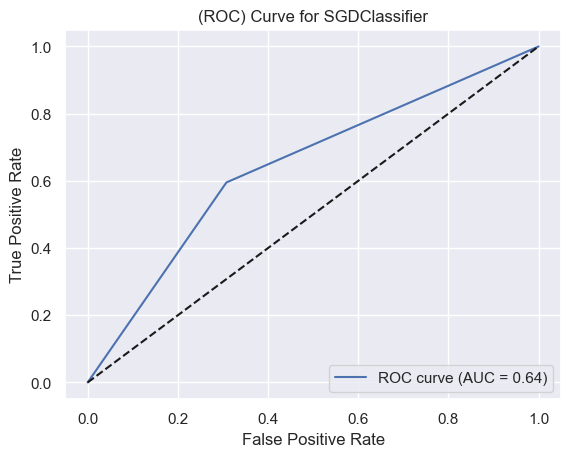

In [399]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % sgd_auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for SGDClassifier')
plt.legend(loc='lower right')
plt.show()

In [400]:
sgd_train_f1_score = calculate_f1_score(sgd_model, X_train_df, y_train)
sgd_eval_f1_score = calculate_f1_score(sgd_model, X_eval_df, y_eval)

# Print the F1 scores
print("F1 Score on Training Set based on SGDClassifier:", sgd_train_f1_score)
print("F1 Score on Evaluation Set based on SGDClassifier:", sgd_eval_f1_score)

F1 Score on Training Set based on SGDClassifier: 0.5714285714285714
F1 Score on Evaluation Set based on SGDClassifier: 0.5494505494505495


In [401]:
# Call the function with your Naive Bayes model and train data
cv_scores, avg_f1_score = perform_cross_validation(sgd_model, X_train_df, y_train, cv=5, scoring='f1')
# Print the cross-validation scores and average F1 score
print("Cross-Validation Scores based on Naive Bayes model:", cv_scores)
print("Average F1 Score based on Naive Bayes model:", avg_f1_score)

Cross-Validation Scores based on Naive Bayes model: [0.63768116 0.60869565 0.62745098 0.45614035 0.67647059]
Average F1 Score based on Naive Bayes model: 0.6012877462197693


In [402]:
results_No_SMOTE= {'model':['Decision Tree','Random Forest','XGBoost','Logistic Regression','Naive Bayes','SGBoost'],
         'f1_score':[dt_f1_score,rf_f1_score,xgb_f1_score,lr_f1_score,nb_f1_score,sgd_f1_score],
         'AUC_score':[dt_auc_score,rf_auc_score,xgb_auc_score,lr_auc_score,nb_auc_score,sgd_auc_score]}

results_No_SMOTE_df= pd.DataFrame(results_No_SMOTE)
results_No_SMOTE_df_sorted = results_No_SMOTE_df.sort_values(by= 'AUC_score', ascending = False)
results_No_SMOTE_df_sorted

,model,f1_score,AUC_score
3,Logistic Regression,0.626506,0.713370
0,Decision Tree,0.602410,0.695055
2,XGBoost,0.588235,0.682234
1,Random Forest,0.578313,0.676740
4,Naive Bayes,0.574713,0.669414
5,SGBoost,0.549451,0.643773


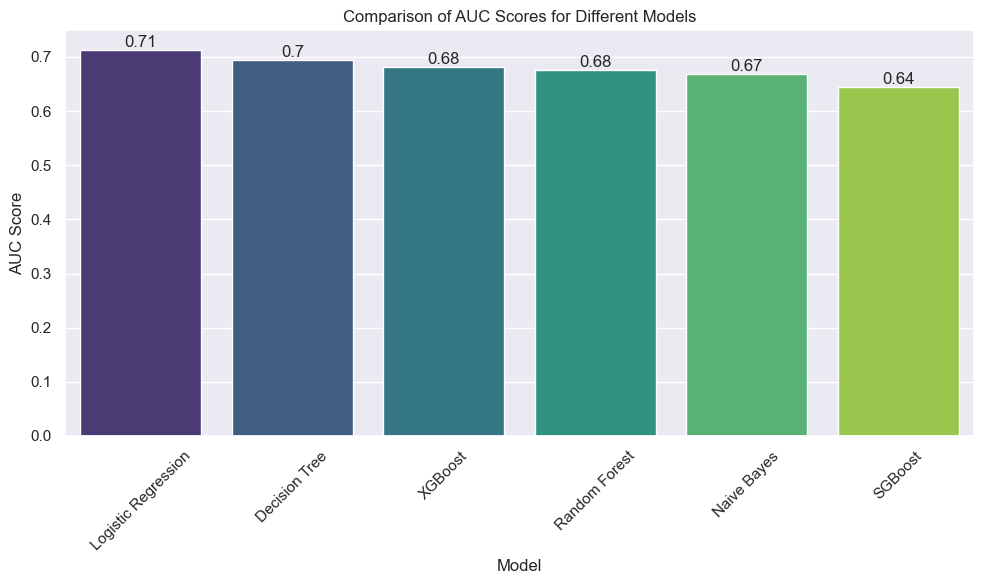

In [403]:
# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=results_No_SMOTE_df_sorted, x='model', y='AUC_score', palette='viridis')

# Add data labels
for i, value in enumerate(results_No_SMOTE_df_sorted['AUC_score']):
    plt.text(i, value, round(value, 2), ha='center', va='bottom')

# Set other plot properties
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.title('Comparison of AUC Scores for Different Models')
plt.tight_layout()
plt.show()

In [411]:
# Get the current working directory
cwd = os.getcwd()

# Specify the relative path to the destination directory
destination = os.path.join(cwd, "Assets")

# Create the "export" directory if it doesn't exist
os.makedirs(destination, exist_ok=True)

# Export the numerical imputer
imputer_filepath = os.path.join(destination, "numerical_imputer.joblib")
dump(numerical_imputer, imputer_filepath)

# Export the scaler
scaler_filepath = os.path.join(destination, "scaler.joblib")
dump(scaler, scaler_filepath)

# Export the logistic regression model
model_filepath = os.path.join(destination, "lr_model.joblib")
dump(lr_model, model_filepath)

# Print the paths to the exported components
print(f"Numerical Imputer exported to: {imputer_filepath}")
print(f"Scaler exported to: {scaler_filepath}")
print(f"Logistic Regression Model exported to: {model_filepath}")

Numerical Imputer exported to: c:\Users\KEMUNTO\Desktop\sepsis_P5\Sepsis_Prediction_FastAPI\Assets\numerical_imputer.joblib
Scaler exported to: c:\Users\KEMUNTO\Desktop\sepsis_P5\Sepsis_Prediction_FastAPI\Assets\scaler.joblib
Logistic Regression Model exported to: c:\Users\KEMUNTO\Desktop\sepsis_P5\Sepsis_Prediction_FastAPI\Assets\lr_model.joblib


In [412]:
!pip list --format=freeze >Assets/requirements.txt